In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def data_reader(name):
  data = pd.read_csv(name, sep=";", header=None)
  data.columns = ["text", "emotion"]
  return data

In [4]:
train = data_reader('train.txt')
train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
classes = train.emotion.unique()
classes_token = {classes[i]:i for i in range(len(classes))}

In [6]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

sentences = []
for item in train.values:
  sentence = item[0].lower()
  word_tokens = tokenizer.tokenize(sentence)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  stemmed = [ps.stem(w) for w in word_tokens]
  sentences.append([stemmed, item[1]])

In [7]:
vocabulary = []

for item in sentences:
    for word in item[0]:
      vocabulary.append(word)

vocabulary = set(vocabulary)

In [8]:
len(vocabulary)

11123

In [9]:
vocab_classes = {word:[0, 0, 0, 0, 0, 0] for word in vocabulary}

In [10]:
classes_len = {i:0 for i in classes}

In [11]:
for c, v in classes_token.items():
  for item in sentences:
    if item[1] == c:
      for word in item[0]:
        vocab_classes[word][v] += 1
        classes_len[c] += 1

In [12]:
classes_len

{'anger': 46797,
 'fear': 40431,
 'joy': 117965,
 'love': 30651,
 'sadness': 95678,
 'surprise': 12871}

In [13]:
def sum_other_lens(cv, classes_len):
  sum = 0
  for c, v in classes_len.items():
    if cv != v:
      sum += classes_len[c]
  return sum

In [14]:
other_lens = {c:sum_other_lens(v, classes_len) for c, v in classes_len.items()}

In [15]:
def sum_word_occ_other_classes(word, cv):
  sum = 0
  for c, v in classes_len.items():
    if cv != v:
      sum += vocab_classes[word][classes_token[c]]
  return sum

In [16]:
probs = {word:[0, 0, 0, 0, 0, 0] for word in vocabulary}

In [17]:
v_len = len(vocabulary)

In [18]:
for word in vocabulary:
  for c, v in classes_token.items():
    cc = (vocab_classes[word][v] + 1) / (classes_len[c] + v_len) 
    oc = (sum_word_occ_other_classes(word, v) + 1) / (other_lens[c] + v_len)
    probs[word][v] = cc / oc

In [19]:
def prob_calculator_for_one_class(c_name, sentence):
  prior = classes_len[c_name] / other_lens[c_name]
  mul = 1
  for word in sentence:
    if word in vocabulary:
      mul *= probs[word][classes_token[c_name]]  
  return mul*prior

In [20]:
def preprocessing(sentence):
  sentence = sentence.lower()
  word_tokens = tokenizer.tokenize(sentence)
  filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  stemmed = [ps.stem(w) for w in word_tokens]
  return stemmed

In [21]:
def argmax(current_probs):
  max_v = -1
  arg = ''
  for c, v in current_probs.items():
    if max_v < v:
      max_v = v
      arg = c
  return arg

In [22]:
def classifier(sentence):
  current_probs = {classes[i]:0 for i in range(len(classes))}
  sentence = preprocessing(sentence)
  for c_name, c_value in classes_token.items():
    c_p = prob_calculator_for_one_class(c_name, sentence)
    current_probs[c_name] = c_p
  return argmax(current_probs)

In [23]:
test = data_reader('test.txt')

In [24]:
test

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


**Predict and calcualte accuracy**

In [25]:
classified = []
all_corrects = 0
for item in test.values:
  p_c = classifier(item[0])
  classified.append([item[0], p_c, item[1]])
  if p_c == item[1]:
    all_corrects +=1

accuracy = all_corrects / len(test.values)

In [26]:
print('Accuracy is: ', accuracy)

Accuracy is:  0.658


Save output dataframe

In [27]:
output = pd.DataFrame(classified)
output.columns = ["text", "predicted_emotion", "emotion"]
output.head()

,text,predicted_emotion,emotion
0,im feeling rather rotten so im not very ambiti...,sadness,sadness
1,im updating my blog because i feel shitty,sadness,sadness
2,i never make her separate from me because i do...,anger,sadness
3,i left with my bouquet of red and yellow tulip...,fear,joy
4,i was feeling a little vain when i did this one,sadness,sadness


In [28]:
output.to_csv('output.csv', index=False)

Calculate accuracy for every classes

In [29]:
class_ac = {}
for c in classes:
  c_c = output[output['emotion'] == c]
  c_c['ok'] = c_c['predicted_emotion'] == c_c['emotion']
  class_ac[c] = c_c['ok'].sum() / len(c_c.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [30]:
class_ac

{'anger': 0.8981818181818182,
 'fear': 0.90625,
 'joy': 0.4776978417266187,
 'love': 0.779874213836478,
 'sadness': 0.685025817555938,
 'surprise': 0.18181818181818182}

Text(0.5, 0, 'Class')

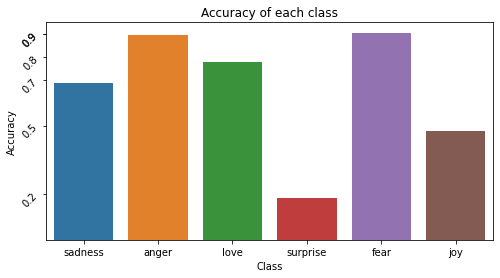

In [31]:
plt.figure(figsize=(8,4))

plt.title("Accuracy of each class")

g = sns.barplot(x=[v for v in class_ac.keys()], y=[v for v in class_ac.values()])
ticks = [float(format(v, ".1f")) for v in class_ac.values()]
g.set_yticks(ticks)
plt.yticks(rotation=45)

plt.ylabel("Accuracy")
plt.xlabel("Class")

**Discoverig most positive words for every classes**

In [32]:
pb = pd.DataFrame(probs)
pb = pb.transpose()
pb.columns = [c for c,v in classes_token.items()]
pb

,sadness,anger,love,surprise,fear,joy
bicycl,1.216459,2.665047,3.888364,7.140223,6.111747,0.920113
button,0.324389,1.421358,0.518448,2.856089,0.814900,0.981453
metabol,1.216459,2.665047,3.888364,7.140223,6.111747,0.920113
southern,1.216459,5.330093,3.888364,7.140223,3.055873,0.920113
mcgarrigl,1.216459,2.665047,3.888364,7.140223,3.055873,1.840225
...,...,...,...,...,...,...
techniqu,1.081297,1.184465,0.864081,4.760148,1.358166,0.408939
quot,0.608229,1.332523,0.486045,2.677583,1.527937,0.575070
exspress,1.216459,2.665047,3.888364,7.140223,3.055873,1.840225
celebr,0.589798,0.484554,1.178292,0.432741,0.555613,1.003759


In [33]:
most_p_word_for_classes = {}
for c in classes:
  c_w = pb[c]
  c_w = c_w.sort_values(ascending=False)
  most_p_word_for_classes[c] = c_w

In [34]:
for c, v in most_p_word_for_classes.items():
  print()
  print('class: ', c)
  print(v)
  print()


class:  sadness
defect        2.432917
countertop    2.432917
rounder       2.432917
barefoot      2.432917
drivel        2.432917
                ...   
honor         0.037429
festiv        0.037429
shaken        0.034266
apprehens     0.034266
cute          0.030411
Name: sadness, Length: 11123, dtype: float64


class:  anger
scafel        5.330093
resembl       5.330093
riku          5.330093
brainstorm    5.330093
becuas        5.330093
                ...   
popular       0.067470
satisfi       0.064218
terrifi       0.059889
belov         0.059223
weird         0.036259
Name: anger, Length: 11123, dtype: float64


class:  love
ange       7.776727
shorter    7.776727
boulder    7.776727
rehears    7.776727
ryder      7.776727
             ...   
stress     0.075871
anxiou     0.074776
agit       0.065351
depress    0.058915
content    0.058915
Name: love, Length: 11123, dtype: float64


class:  surprise
houston    14.280445
wot        14.280445
nemo       14.280445
slalom     14.